In [350]:
library(chromVARmotifs)
library(chromVAR)
library(BSgenome.Mmusculus.UCSC.mm10)
library(motifmatchr)
library(BiocParallel)
library(SummarizedExperiment)
library(gplots)
library(circlize)
library(ComplexHeatmap)
register(MulticoreParam(4)) # Use 8 cores
library(plyr)
library(dplyr)
library(DESeq2)
library(VennDiagram)
library(wordcloud2)

In [349]:
BiocManager::install('wordcloud2')

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)
Installing package(s) 'wordcloud2'
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'ade4', 'CNEr', 'DirichletMultinomial', 'evaluate',
  'GenomicFeatures', 'IRkernel', 'KEGGREST', 'remotes', 'repr', 'Rsamtools',
  'seqLogo', 'TFBSTools'


In [22]:
# Read the ATAC-seq read counts data for each sample and count the motifs at each interval
se <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/ATAC_peaks_Etv2_reprogramming.rds')))
se <- se[, colData(se)$group %in% c('EB_NoDox_D25', 'EB_Dox_D25', 'EB_Dox_D25_Flk1pos', 'MEF_NoDox', 'MEF_Dox_D1', 'MEF_Dox_D2', 'MEF_Dox_D7', 'MEF_Dox_D7_Flk1pos')]
se <- se[rowSums(assays(se)$counts > 0) >= 2]
is_MEF <- colData(se)$group %in% c('MEF_NoDox', 'MEF_Dox_D1', 'MEF_Dox_D2', 'MEF_Dox_D7', 'MEF_Dox_D7_Flk1pos')
is_EB <- colData(se)$group %in% c('EB_NoDox_D25', 'EB_Dox_D25', 'EB_Dox_D25_Flk1pos')
se

class: RangedSummarizedExperiment 
dim: 168305 16 
metadata(0):
assays(1): counts
rownames(168305): chr1 chr1 ... chrY chrY
rowData names(0):
colnames: NULL
colData names(9): study_accession run ... tissue bw_file

In [75]:
# Read scRNA-seq of MEF reprogramming
se_sc <- readRDS(gzcon(url('https://s3.msi.umn.edu/garry_projects/etv2_pioneer/processed_Etv2_scRNAseq.rds')))
colData(se_sc)$group <- colData(se_sc)$group %>% factor(c('MEF_Dox_D1', 'MEF_NoDox', 'MEF_Dox_D2', 'MEF_Dox_D7a', 'MEF_Dox_D7b'))
colData(se_sc)$group <- revalue(colData(se_sc)$group, c("MEF_Dox_D1"="MEF_NoDox", "MEF_NoDox"="MEF_Dox_D1"))
invalid <- assays(se_sc)$counts[rowData(se_sc)$name == 'Etv2', ] > 0 & colData(se_sc)$group == 'MEF_NoDox' 
se_sc <- se_sc[, !invalid]
table(colData(se_sc)$group)



  MEF_NoDox  MEF_Dox_D1  MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b 
       3539         948        2936        7202         827 

In [76]:
# Find the DE genes between MEF D7 Flk1+ cells and undifferentiated MEF
X <- assays(se_sc)$scaled_counts
j_MEF_NoDox <- colData(se_sc)$group %in% 'MEF_NoDox'
j_MEF_Dox_D7_Flk1pos <- colData(se_sc)$group %in% c('MEF_Dox_D7b')
pvalues <- mclapply(
  1:nrow(X), 
  function(i) wilcox.test(X[i, j_MEF_Dox_D7_Flk1pos], X[i, j_MEF_NoDox])$p.value,
  mc.cores = 4
) %>% unlist()

In [77]:
# Read bulk RNA-seq of EB differentiation and 
# find the DE genes between no dox and Flk1+ cells post induction
se_bulk <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2RNA-seq_version=20190909a/se.rds')))
se_bulk <- DESeqDataSet(se_bulk, design = ~ group)
se_bulk <- estimateSizeFactors(se_bulk)
se_bulk <- DESeq(se_bulk)
assays(se_bulk)$normalized_counts <- log2(counts(se_bulk, normalized = TRUE) + 1)
res <- results(se_bulk, contrast = c('group', 'EB_Dox_D25_Flk1pos_Etv2', 'EB_NoDox_D25_Etv2'))


Warning message in DESeqDataSet(se_bulk, design = ~group):
“some variables in design formula are characters, converting to factors”using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [78]:
# Merge the scRNA-seq and bulk RNA-seq by gene symbols.
d_rna_merge <- merge(
  data.frame(
    symbol = rownames(res), 
    EB_log2FoldChange = res$log2FoldChange, 
    EB_pvalue = res$pvalue
  ),
  data.frame(
    symbol = rowData(se_sc)$name, 
    MEF_log2FoldChange = rowMeans(X[, j_MEF_Dox_D7_Flk1pos]) - rowMeans(X[, j_MEF_NoDox]), 
    MEF_pvalue = pvalues
  ),
  by.x = 'symbol',
  by.y = 'symbol'
) %>%
  filter(!is.na(EB_pvalue) & !is.na(MEF_pvalue)) %>%
  filter(!duplicated(symbol))
rownames(d_rna_merge) <- d_rna_merge$symbol
d_rna_merge %>% filter(symbol %in% c('Etv2', 'Kdr', 'Emcn', 'Cdh5', 'Runx1'))

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue
Cdh5,7.534863,1.315189e-43,1.5647254,0.000000e+00
Emcn,5.908320,6.634402e-03,1.4578175,0.000000e+00
Etv2,5.462880,0.000000e+00,1.1238240,6.723323e-297
Kdr,7.093824,0.000000e+00,1.7277261,0.000000e+00
Runx1,1.891086,1.139845e-11,-0.3844311,2.239118e-25


In [79]:
# chromVAR analysis
data("mouse_pwms_v2") 
se <- addGCBias(se, genome = BSgenome.Mmusculus.UCSC.mm10)
motif_ix <- matchMotifs(mouse_pwms_v2, se, genome = 'mm10')

In [80]:
# Looking for significantly changed motifs in EB
valid <- rowSums(assays(se[, is_EB])$counts > 0) >= 2
dev_EB <- computeDeviations(object = se[valid, is_EB], annotations = motif_ix[valid, ])
v_EB <- computeVariability(dev_EB)

In [81]:
# Looking for significantly changed motifs in MEF
valid <- rowSums(assays(se[, is_MEF])$counts > 0) >= 2
dev_MEF <- computeDeviations(object = se[valid, is_MEF], annotations = motif_ix[valid, ])
v_MEF <- computeVariability(dev_MEF)

number of significantly changed motifs in EB: 729


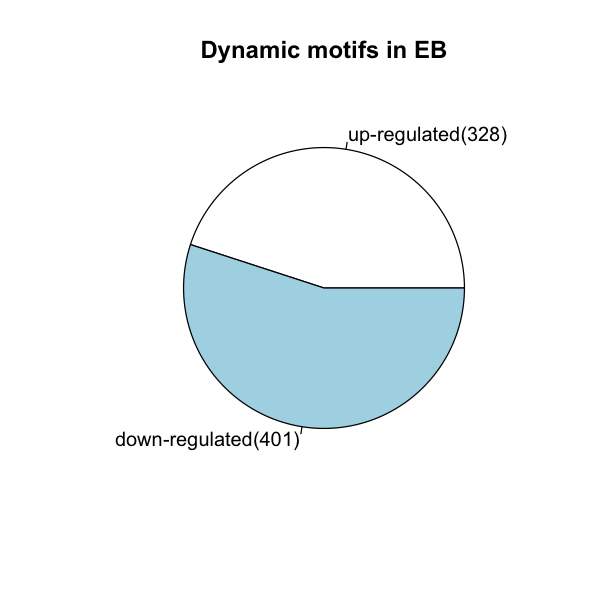

In [82]:
d_EB_Dox_D25_Flk1pos <- rowMeans(assays(dev_EB)$deviations[, colData(dev_EB)$group %in% c('EB_Dox_D25_Flk1pos')])
d_EB_NoDox_D25 <- rowMeans(assays(dev_EB)$deviations[, colData(dev_EB)$group %in% c('EB_NoDox_D25')])
n_EB_up <- sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos > d_EB_NoDox_D25)
n_EB_down <- sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos < d_EB_NoDox_D25)
cat(sprintf('number of significantly changed motifs in EB: %d\n', sum(v_EB$p_value_adj < 0.05)))
options(repr.plot.width=5, repr.plot.height=5)
pie(
  c(n_EB_up, n_EB_down), 
  labels = sprintf(c('up-regulated(%d)', 'down-regulated(%d)'), c(n_EB_up, n_EB_down)),
  main = "Dynamic motifs in EB"
)

number of significantly changed motifs in MEF: 747


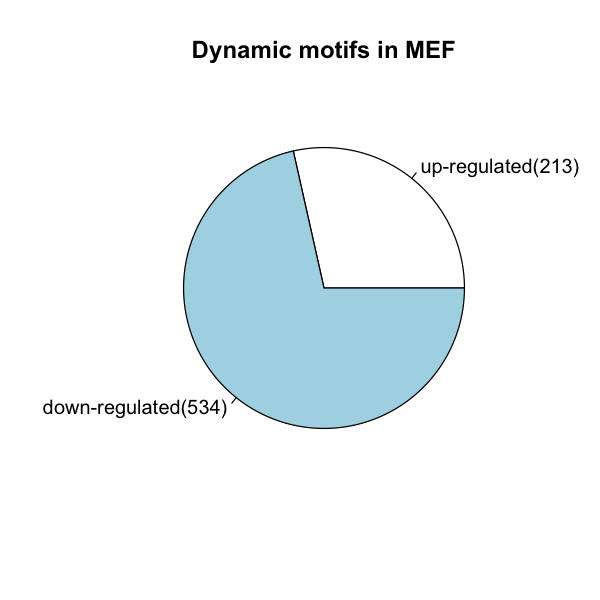

In [83]:
d_MEF_Dox_D7_Flk1pos <- rowMeans(assays(dev_MEF)$deviations[, colData(dev_MEF)$group %in% c('MEF_Dox_D7_Flk1pos')])
d_MEF_NoDox <- rowMeans(assays(dev_MEF)$deviations[, colData(dev_MEF)$group %in% c('MEF_NoDox')])
n_MEF_up <- sum(v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos > d_MEF_NoDox)
n_MEF_down <- sum(v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos < d_MEF_NoDox)
cat(sprintf('number of significantly changed motifs in MEF: %d\n', sum(v_MEF$p_value_adj < 0.05)))
options(repr.plot.width=5, repr.plot.height=5)
pie(
  c(n_MEF_up, n_MEF_down), 
  labels = sprintf(c('up-regulated(%d)', 'down-regulated(%d)'), c(n_MEF_up, n_MEF_down)),
  main = "Dynamic motifs in MEF"
)

(polygon[GRID.polygon.5496], polygon[GRID.polygon.5497], polygon[GRID.polygon.5498], polygon[GRID.polygon.5499], text[GRID.text.5500], text[GRID.text.5501], text[GRID.text.5502], text[GRID.text.5503], text[GRID.text.5504]) 

,name,variability,bootstrap_lower_bound,bootstrap_upper_bound,p_value,p_value_adj
ENSMUSG00000021359_LINE1_Tcfap2a_D_N1,Tcfap2a,2.609467,1.1540973,3.197058,2.330685e-06,3.902131e-06
ENSMUSG00000025927_LINE5_Tcfap2b_D,Tcfap2b,1.423373,0.5263420,1.868951,7.163587e-02,8.454754e-02
ENSMUSG00000028640_LINE6_Tcfap2c_D,Tcfap2c,1.978427,0.7298325,2.700986,1.503909e-03,2.054800e-03
ENSMUSG00000042477_LINE7_Tcfap2e_D,Tcfap2e,2.931796,1.3270640,3.861324,3.734691e-08,6.878056e-08
ENSMUSG00000042596_LINE8_Tcfap2d_I,Tcfap2d,7.291416,2.3545550,9.510664,2.206521e-55,1.354559e-54
ENSMUSG00000004661_LINE10_Arid3b_D,Arid3b,1.193429,0.5252746,1.599318,2.117698e-01,2.381736e-01


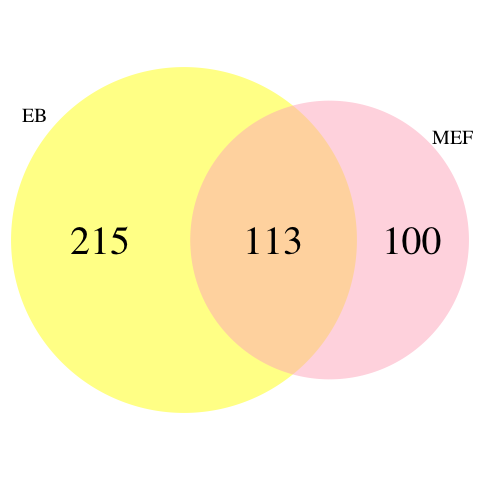

In [323]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos > d_EB_NoDox_D25),
  area2 = sum(v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos > d_MEF_NoDox), 
  cross.area = sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos > d_EB_NoDox_D25 & v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos > d_MEF_NoDox),
  category = c("EB", 'MEF'), 
  lty = "blank", 
  fill = c("yellow1", "pink1"),
  cex = 2,
  cat.cex = 1
)

(polygon[GRID.polygon.38], polygon[GRID.polygon.39], polygon[GRID.polygon.40], polygon[GRID.polygon.41], text[GRID.text.42], text[GRID.text.43], text[GRID.text.44], text[GRID.text.45], text[GRID.text.46]) 

[1] 401

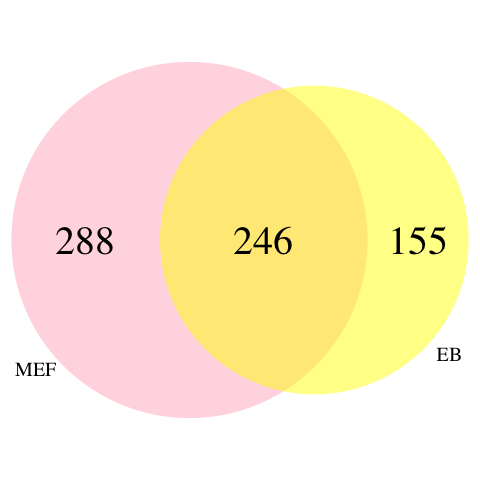

In [88]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos < d_EB_NoDox_D25),
  area2 = sum(v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos < d_MEF_NoDox), 
  cross.area = sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos < d_EB_NoDox_D25 & v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos < d_MEF_NoDox),
  category = c("EB", 'MEF'), 
  lty = "blank", 
  fill = c("yellow1", "pink1"),
  cex = 2,
  cat.cex = 1
)


In [112]:
# chrromVAR analysis of both EB and MEF
data("homer_pwms") 
se <- addGCBias(se, genome = BSgenome.Mmusculus.UCSC.mm10)
motif_ix <- matchMotifs(homer_pwms, se, genome = 'mm10')
dev <- computeDeviations(object = se, annotations = motif_ix)
v <- computeVariability(dev)

In [114]:
v[grep('Etv2', v$name), ]

,name,variability,bootstrap_lower_bound,bootstrap_upper_bound,p_value,p_value_adj
Etv2(ETS)/ES-ER71-ChIP-Seq(GSE59402)/Homer(0.967),Etv2(ETS),21.93539,13.5372,27.60149,0,0


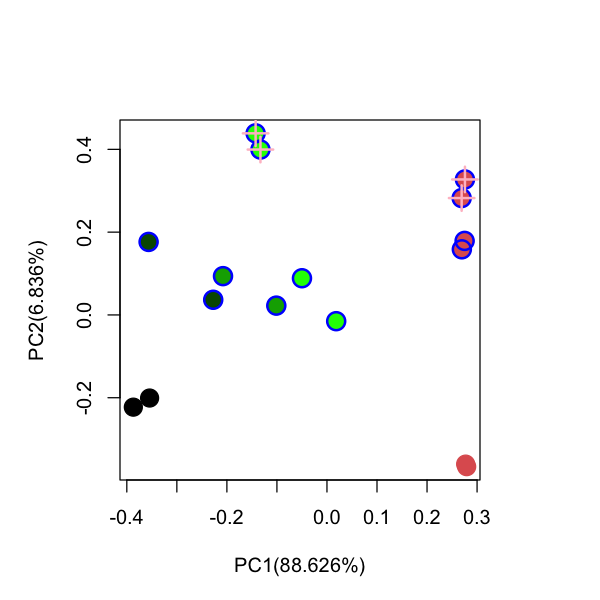

In [120]:
# Plot PCA of the motif deviations 
m <- v$p_value_adj < 0.05
s <- prcomp(assays(dev)$z[m, ])
eigs <- s$sdev^2

colData(se)$cell <- gsub('(.+?)_.+', '\\1', colData(se)$group)
colData(se)$dox <- rep("Dox", ncol(se))
colData(se)$dox[grep('NoDox', colData(se)$group)] <- 'NoDox'
MEF_cols <- colorpanel(4, low = 'black', high = 'green')
EB_cols <- colorpanel(3, low = 'gray', high = 'red')
group2col <- c(
  'MEF_NoDox' = MEF_cols[1],
  'MEF_Dox_D1' = MEF_cols[2],
  'MEF_Dox_D2' = MEF_cols[3],
  'MEF_Dox_D7' = MEF_cols[4],
  'MEF_Dox_D7_Flk1pos' = MEF_cols[4],

  'EB_NoDox_D0' = EB_cols[1],
  'EB_NoDox_D25' = EB_cols[2],
  'EB_NoDox_D3' = EB_cols[3],
  'EB_NoDox_D3_Flk1pos' = EB_cols[3],

  'EB_Dox_D0' = EB_cols[1],
  'EB_Dox_D25' = EB_cols[2],
  'EB_Dox_D25_Flk1pos' = EB_cols[2],
  'EB_Dox_D3' = EB_cols[3],
  'EB_Dox_D3_Flk1pos' = EB_cols[3]
)
is_flk1pos <- grepl('Flk1pos', colData(se)$group)
is_dox <- grepl('_Dox_', colData(se)$group)
pc_x <- 1; pc_y <- 2

par(mar = c(5, 5, 5 , 5))
options(repr.plot.width=5, repr.plot.height=5)
plot(s$rotation[, pc_x], s$rotation[, pc_y], pch = 21, bg = group2col[colData(se)$group], col = group2col[colData(se)$group], cex = 2, xlab = sprintf('PC%d(%.3f%%)', pc_x, eigs[pc_x] / sum(eigs) * 100), ylab = sprintf('PC%d(%.3f%%)', pc_y, eigs[pc_y] / sum(eigs) * 100))
points(s$rotation[is_dox, pc_x], s$rotation[is_dox, pc_y], pch = 21, col = 'blue', cex = 2, lwd = 2)
points(s$rotation[is_flk1pos, pc_x], s$rotation[is_flk1pos, pc_y], pch = 3, col = 'pink', cex = 2, lwd = 2)

In [121]:
head(d_rna_merge)

,symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue
0610005C13Rik,0610005C13Rik,2.2176660,0.003103568,0.01211949,3.863364e-02
0610009B22Rik,0610009B22Rik,0.1199313,0.512962604,0.65280279,4.100291e-11
0610009O20Rik,0610009O20Rik,0.1195349,0.294842818,-0.15080844,1.526321e-11
0610010F05Rik,0610010F05Rik,0.1665818,0.290078194,-0.61274181,1.356258e-54
0610010K14Rik,0610010K14Rik,-0.4331971,0.001113826,-0.16675903,2.115115e-17
0610012G03Rik,0610012G03Rik,-0.4166797,0.027842812,-0.14043973,5.509245e-06


In [128]:
d_motif <- data.frame(
  symbol = v_MEF$name,
  MEF_motif_diff = d_MEF_Dox_D7_Flk1pos - d_MEF_NoDox,
  MEF_motif_pvalue = v_MEF$p_value_adj,
  EB_motif_diff = d_EB_Dox_D25_Flk1pos - d_EB_NoDox_D25,
  EB_motif_pvalue = v_EB$p_value_adj
)
head(d_motif)

,symbol,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
ENSMUSG00000021359_LINE1_Tcfap2a_D_N1,Tcfap2a,-0.04589213,2.169474e-37,-0.0152832324,3.902131e-06
ENSMUSG00000025927_LINE5_Tcfap2b_D,Tcfap2b,-0.02545276,6.334336e-03,-0.0020625177,8.454754e-02
ENSMUSG00000028640_LINE6_Tcfap2c_D,Tcfap2c,-0.04082094,3.183033e-29,-0.0000541479,2.054800e-03
ENSMUSG00000042477_LINE7_Tcfap2e_D,Tcfap2e,-0.03391513,1.017990e-02,-0.0264604956,6.878056e-08
ENSMUSG00000042596_LINE8_Tcfap2d_I,Tcfap2d,0.03621544,2.240467e-92,-0.0212842591,1.354559e-54
ENSMUSG00000004661_LINE10_Arid3b_D,Arid3b,-0.01971070,7.487167e-03,-0.0073175727,2.381736e-01


In [126]:
# a merged data frame that include EB/MEF and RNA-seq/motif information
d_merge <- merge(d_rna_merge, d_motif, by.x = 'symbol', by.y = 'symbol')
d_merge %>% filter(symbol == 'Etv2')

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
Etv2,5.46288,0,1.123824,6.723323e-297,0.3763225,0,0.3174181,0


(polygon[GRID.polygon.5541], polygon[GRID.polygon.5542], polygon[GRID.polygon.5543], polygon[GRID.polygon.5544], text[GRID.text.5545], text[GRID.text.5546], text[GRID.text.5547], text[GRID.text.5548], text[GRID.text.5549]) 

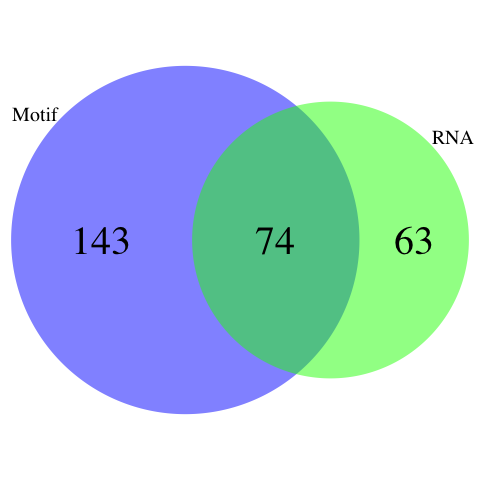

In [329]:
# The commonly up-regulated TFs (expresion and ATAC-seq counts) in EB
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(d_merge$EB_motif_pvalue < 0.05 & d_merge$EB_motif_diff > 0),
  area2 = sum(d_merge$EB_pvalue < 0.05 & d_merge$EB_log2FoldChange > 0),
  cross.area = sum(d_merge$EB_motif_pvalue < 0.05 & d_merge$EB_motif_diff > 0 & d_merge$EB_pvalue < 0.05 & d_merge$EB_log2FoldChange > 0),
  category = c("Motif", 'RNA'), 
  lty = "blank", 
  fill = c("blue", "green"),
  cex = 2,
  cat.cex = 1
)


In [384]:
g <- d_merge %>% filter(EB_motif_pvalue < 0.05 & EB_motif_diff > 0 & EB_pvalue < 0.05 & EB_log2FoldChange > 0)
set.seed(1)
df <- data.frame(
  word = g$symbol,
  freq = round(g$EB_log2FoldChange * 10)
)
options(repr.plot.width=6, repr.plot.height=6)
wordcloud2(df, color = 'red')

HTML widgets cannot be represented in plain text (need html)

(polygon[GRID.polygon.92], polygon[GRID.polygon.93], polygon[GRID.polygon.94], polygon[GRID.polygon.95], text[GRID.text.96], text[GRID.text.97], text[GRID.text.98], text[GRID.text.99], text[GRID.text.100]) 

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
Ar,1.91818995,2.339774e-07,0.301294398,1.430974e-02,0.090381099,4.192826e-20,0.007540557,4.177305e-01
Elk1,0.13196628,2.763154e-01,0.067093822,2.035966e-03,0.008000901,7.305380e-105,0.074442926,2.070799e-83
Elk3,3.89322129,7.293291e-176,0.646506631,2.385687e-28,0.008891037,5.145914e-105,0.074017031,3.392317e-82
Erf,0.17156413,1.042432e-01,0.006417363,3.863698e-09,0.245899021,0.000000e+00,0.233121293,0.000000e+00
Etv2,5.46287962,0.000000e+00,1.123823968,6.723323e-297,0.376322543,0.000000e+00,0.317418052,0.000000e+00
Fev,9.34336647,1.459927e-10,0.072941582,3.982156e-07,0.102840529,6.883088e-183,0.145298889,0.000000e+00
Fli1,10.82302145,5.097621e-83,0.321401014,8.927435e-03,0.109415248,4.124625e-245,0.151070465,0.000000e+00
Foxo1,-0.04173841,7.448086e-01,0.744617690,1.833507e-62,0.047784161,3.823272e-25,0.063584216,1.128498e-85
Hic1,-1.93070041,7.558882e-02,0.351197102,7.362553e-06,0.018515859,2.506830e-24,-0.063444821,1.247138e-65
Hivep2,-0.23166032,2.082278e-01,0.184627522,3.150661e-02,0.087389572,2.356052e-46,-0.041413122,8.628422e-52


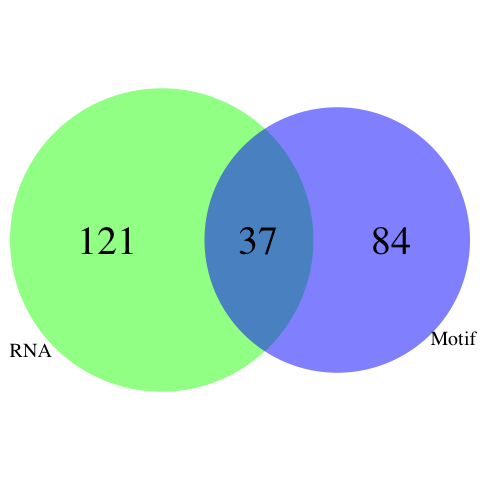

In [134]:
# The commonly up-regulated TFs (expresion and ATAC-seq counts) in MEF
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(d_merge$MEF_motif_pvalue < 0.05 & d_merge$MEF_motif_diff > 0),
  area2 = sum(d_merge$MEF_pvalue < 0.05 & d_merge$MEF_log2FoldChange > 0),
  cross.area = sum(d_merge$MEF_motif_pvalue < 0.05 & d_merge$MEF_motif_diff > 0 & d_merge$MEF_pvalue < 0.05 & d_merge$MEF_log2FoldChange > 0),
  category = c("Motif", 'RNA'), 
  lty = "blank", 
  fill = c("blue", "green"),
  cex = 2,
  cat.cex = 1
)
d_merge %>% fiter(MEF_motif_pvalue < 0.05 & MEF_motif_diff > 0 & MEF_pvalue < 0.05 & MEF_log2FoldChange > 0)

In [383]:
g <- d_merge %>% filter(MEF_motif_pvalue < 0.05 & MEF_motif_diff > 0 & MEF_pvalue < 0.05 & MEF_log2FoldChange > 0)
set.seed(1)
df <- data.frame(
  word = g$symbol,
  freq = round(g$MEF_log2FoldChange * 10)
)
options(repr.plot.width=6, repr.plot.height=6)
wordcloud2(df, color = 'red')

HTML widgets cannot be represented in plain text (need html)

(polygon[GRID.polygon.119], polygon[GRID.polygon.120], polygon[GRID.polygon.121], polygon[GRID.polygon.122], text[GRID.text.123], text[GRID.text.124], text[GRID.text.125], text[GRID.text.126], text[GRID.text.127]) 

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
Arid5b,-0.9613975,1.627464e-04,-0.432987723,2.920519e-39,-0.0188629809,5.623307e-01,-0.107582235,5.517654e-12
Dbp,-1.5129366,3.682397e-07,0.369300683,7.220114e-23,-0.0785266936,4.518493e-01,-0.023753073,9.414290e-06
Dlx2,-3.7050465,3.185797e-02,-0.369932588,7.825255e-19,-0.0873921756,6.699290e-30,-0.101280334,8.233842e-23
Dnajc21,-1.3965521,1.450235e-25,-0.458842744,1.776450e-43,0.0178346978,3.554237e-25,-0.010178398,1.057661e-42
En1,-4.2319297,4.529304e-05,0.062409536,4.954577e-03,0.0228718186,9.966475e-01,-0.043696314,4.480820e-30
Eomes,-3.4036983,4.660844e-188,-0.174231804,9.963833e-05,-0.0321561981,1.025522e-08,-0.147693094,3.836593e-242
Foxa2,-5.3567505,1.593324e-44,-0.034002545,9.363751e-02,-0.0580013462,3.052398e-27,-0.089065628,2.888652e-60
Foxc1,-1.0402297,2.641499e-02,0.171447898,2.059070e-03,-0.0985535644,2.584814e-130,-0.027223042,1.533312e-05
Foxk2,-0.3424798,2.793676e-04,-0.334513252,8.676755e-32,-0.0532878029,6.899578e-32,-0.022500608,8.268185e-05
Foxo4,-0.5383924,2.284024e-09,0.015859299,1.431832e-02,-0.0313264108,2.313939e-26,-0.041816853,4.159851e-15


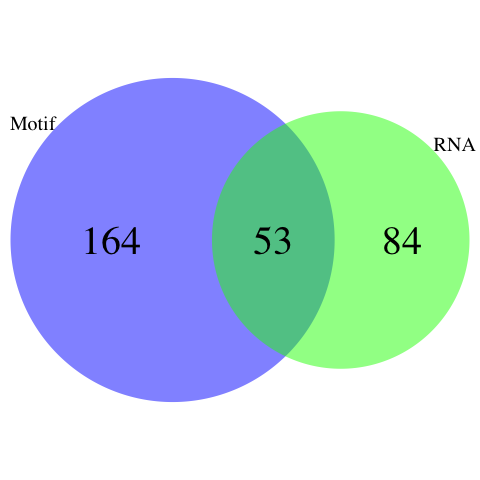

In [137]:
# The commonly down-regulated TFs (expresion and ATAC-seq counts) in EB
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(d_merge$EB_motif_pvalue < 0.05 & d_merge$EB_motif_diff > 0),
  area2 = sum(d_merge$EB_pvalue < 0.05 & d_merge$EB_log2FoldChange > 0),
  cross.area = sum(d_merge$EB_motif_pvalue < 0.05 & d_merge$EB_motif_diff < 0 & d_merge$EB_pvalue < 0.05 & d_merge$EB_log2FoldChange < 0),
  category = c("Motif", 'RNA'), 
  lty = "blank", 
  fill = c("blue", "green"),
  cex = 2,
  cat.cex = 1
)
d_merge %>% filter(EB_motif_pvalue < 0.05 & EB_motif_diff < 0 & EB_pvalue < 0.05 & EB_log2FoldChange < 0)

In [387]:
g <- d_merge %>% filter(EB_motif_pvalue < 0.05 & EB_motif_diff < 0 & EB_pvalue < 0.05 & EB_log2FoldChange < 0)
set.seed(1)
df <- data.frame(
  word = g$symbol,
  freq = round(-g$EB_log2FoldChange * 10)
)
options(repr.plot.width=6, repr.plot.height=6)
wordcloud2(df, color = 'blue')

HTML widgets cannot be represented in plain text (need html)

(polygon[GRID.polygon.128], polygon[GRID.polygon.129], polygon[GRID.polygon.130], polygon[GRID.polygon.131], text[GRID.text.132], text[GRID.text.133], text[GRID.text.134], text[GRID.text.135], text[GRID.text.136]) 

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
Ahctf1,-0.37710523,2.513277e-03,-0.57780063,5.493859e-54,-0.032531018,8.898420e-16,0.023007245,4.775502e-08
Arid3b,-1.45908668,7.382937e-55,-0.12249523,6.829787e-05,-0.019710698,6.047327e-03,-0.007317573,2.117698e-01
Arid5a,-0.55322854,2.777540e-01,-0.06757413,3.591916e-04,-0.044448896,9.906690e-09,-0.005459605,3.543297e-01
Arnt2,0.93608919,3.395964e-13,-0.05789018,1.190822e-04,-0.062202197,3.329845e-47,0.010780852,3.543104e-02
Cdc5l,-0.03067072,7.916518e-01,-0.05323033,2.171668e-08,-0.026070761,7.269712e-09,-0.060699030,5.294987e-10
Cic,-0.07215650,4.952031e-01,-0.04109121,3.970114e-10,-0.127637902,1.467782e-136,-0.028002809,1.308087e-06
Crem,-0.12784665,6.603090e-01,-0.02232919,1.172652e-07,-0.027503393,5.655216e-39,0.099432969,4.287361e-34
Ctcf,-0.07836705,4.731392e-01,-0.24831739,1.552112e-24,-0.003260298,3.386515e-95,-0.030039855,3.380348e-53
Dlx1,4.30839003,6.183562e-02,-0.31237893,8.027666e-16,-0.032812221,4.413326e-37,-0.047316077,2.547290e-29
Dlx2,-3.70504650,3.185797e-02,-0.36993259,7.825255e-19,-0.087392176,6.699290e-30,-0.101280334,8.233842e-23


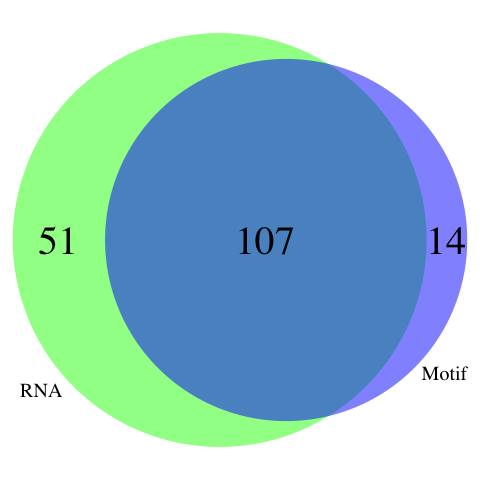

In [138]:
# The commonly down-regulated TFs (expresion and ATAC-seq counts) in MEF
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(d_merge$MEF_motif_pvalue < 0.05 & d_merge$MEF_motif_diff > 0),
  area2 = sum(d_merge$MEF_pvalue < 0.05 & d_merge$MEF_log2FoldChange > 0),
  cross.area = sum(d_merge$MEF_motif_pvalue < 0.05 & d_merge$MEF_motif_diff < 0 & d_merge$MEF_pvalue < 0.05 & d_merge$MEF_log2FoldChange < 0),
  category = c("Motif", 'RNA'), 
  lty = "blank", 
  fill = c("blue", "green"),
  cex = 2,
  cat.cex = 1
)
d_merge %>% filter(MEF_motif_pvalue < 0.05 & MEF_motif_diff < 0 & MEF_pvalue < 0.05 & MEF_log2FoldChange < 0)

In [388]:
g <- d_merge %>% filter(MEF_motif_pvalue < 0.05 & MEF_motif_diff < 0 & MEF_pvalue < 0.05 & MEF_log2FoldChange < 0)
set.seed(1)
df <- data.frame(
  word = g$symbol,
  freq = round(-g$MEF_log2FoldChange * 10)
)
options(repr.plot.width=6, repr.plot.height=6)
wordcloud2(df, color = 'blue')

HTML widgets cannot be represented in plain text (need html)

In [217]:
# Generate a heatmap that include commonly up- and down-regulated TFs in both MEF and EB
d_common <- d_merge %>%
  filter(
    (EB_pvalue < 0.05 & MEF_pvalue < 0.05) & 
    ( 
      (MEF_log2FoldChange < 0 & EB_log2FoldChange < 0 & MEF_motif_diff < 0 & EB_motif_diff < 0) |
      (MEF_log2FoldChange > 0 & EB_log2FoldChange > 0 & MEF_motif_diff > 0 & EB_motif_diff > 0)
    )
  ) %>% 
  mutate(symbol = as.character(symbol)) %>%
  arrange(desc(EB_log2FoldChange))
d_common

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
Fli1,10.8230215,5.097621e-83,0.32140101,8.927435e-03,0.109415248,4.124625e-245,0.151070465,0.000000e+00
Fev,9.3433665,1.459927e-10,0.07294158,3.982156e-07,0.102840529,6.883088e-183,0.145298889,0.000000e+00
Etv2,5.4628796,0.000000e+00,1.12382397,6.723323e-297,0.376322543,0.000000e+00,0.317418052,0.000000e+00
Elk3,3.8932213,7.293291e-176,0.64650663,2.385687e-28,0.008891037,5.145914e-105,0.074017031,3.392317e-82
Myt1l,3.8699385,4.340639e-08,0.01211397,3.863364e-02,0.166475787,2.348087e-286,0.039314149,6.438231e-16
Ar,1.9181900,2.339774e-07,0.30129440,1.430974e-02,0.090381099,4.192826e-20,0.007540557,4.177305e-01
Prdm11,1.4644595,1.509044e-03,0.13104263,4.889264e-02,0.068463818,5.325374e-05,0.029811185,2.348418e-01
Prdm1,1.4226784,1.537160e-09,0.08493177,4.333695e-08,0.002781776,5.682830e-01,0.008921952,1.993584e-03
Xbp1,0.7029344,1.363983e-09,0.69789803,1.241681e-20,0.001556108,2.366544e-13,0.058232051,3.924630e-10
Irf9,0.5854970,4.170048e-03,0.22183804,1.615548e-02,0.027911480,1.194873e-04,0.040888376,3.524614e-04


In [255]:
n <- rowData(se_bulk)$refseq_mrna %in% d_common$symbol
cn <- c('EB_NoDox_D25_Etv2', 'EB_Dox_D25_Etv2', 'EB_Dox_D25_Flk1pos_Etv2')
m <- which(colData(se_bulk)$group %in% cn)
m <- m[order(factor(colData(se_bulk)$group[m], cn)
is_flk1pos <- grepl('Flk1pos', colData(se_bulk)$group)
is_dox <- grepl('_Dox_', colData(se_bulk)$group)
X_bulk <- assays(se_bulk[n, m])$normalized_counts %>%
  t() %>%
  scale() %>%
  t()
rownames(X_bulk) <- rowData(se_bulk)$refseq_mrna[n]
X_bulk <- X_bulk[d_common$symbol, ]
X_bulk

Fli1,-1.17367216,-1.3787353,0.47844102,0.495934002,0.7604422,0.8175903
Fev,-1.15816833,-1.4135099,0.65302829,0.577199575,0.6453674,0.6960830
Etv2,-1.32616064,-1.2525618,0.61256255,0.581580263,0.7062182,0.6783614
Elk3,-1.29834803,-1.2831519,0.62938344,0.678193811,0.6492836,0.6246391
Myt1l,-1.06514624,-1.3810735,0.27036077,0.360764705,0.6756317,1.1394627
Ar,-0.90751815,-1.5719330,0.49750138,0.580726726,0.4370081,0.9642149
Prdm11,-0.63693237,-1.0811322,0.62445514,-0.941431362,0.8193571,1.2156838
Prdm1,-1.15982279,-1.3373156,0.62968633,0.176588784,0.9132562,0.7776071
Xbp1,-0.86278005,-1.5637637,0.30627062,0.328076428,0.9337361,0.8584606
Irf9,-0.81861511,-0.2128386,-0.66182833,-0.817977807,1.1455129,1.3657470
Smarcc2,-1.66928329,-0.6708307,0.39171409,0.202811797,0.7221819,1.0234062


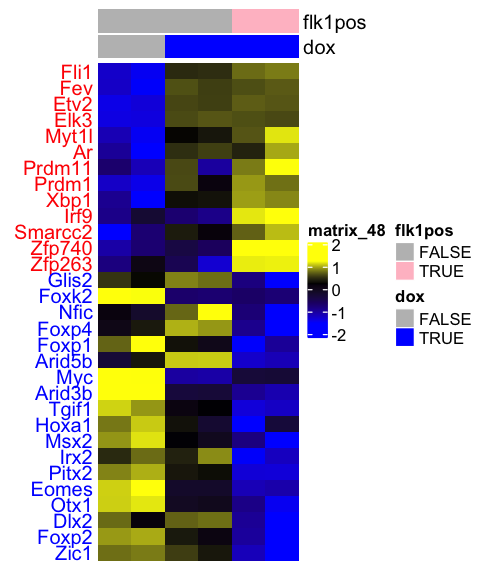

In [256]:
column_annotation <- HeatmapAnnotation(
  flk1pos = is_flk1pos[m],
  dox = is_dox[m],
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray')
  )
)
mark_col <- rep('red', nrow(X_bulk))
mark_col[rownames(X_bulk) %in% d_common[d_common$MEF_log2FoldChange < 0, 'symbol']] <- 'blue'
col_fun <- colorRamp2(quantile(X_bulk, c(0.05, 0.5, 0.95)), c("blue", "black", "yellow"))

options(repr.plot.width=4, repr.plot.height=4.75)
Heatmap(
  X_bulk,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  top_annotation = column_annotation,
  show_row_names = TRUE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE,
  row_names_side = "left",
  row_names_gp = gpar(col = mark_col)
)

In [299]:
n <- rowData(se_sc)$name %in% d_common$symbol
cn <- c('MEF_NoDox', 'MEF_Dox_D7a', 'MEF_Dox_D7b')
m <- which(colData(se_sc)$group %in% cn)
m <- m[order(factor(colData(se_sc)$group[m], cn))]
is_flk1pos <-  colData(se_sc)$group == 'MEF_Dox_D7b'
is_dox <- colData(se_sc)$group != 'MEF_NoDox'
X_sc <- assays(se_sc[n, m])$scaled_counts
rownames(X_sc) <- rowData(se_sc)$name[n]
X_sc <- X_sc[d_common$symbol, ]
X_sc[1:10, 1:10]

Fli1,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421
Fev,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135
Etv2,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880
Elk3,1.22651495,-1.05472462,0.50385770,1.24119694,-1.05472462,0.69004071,-0.26701935,-1.05472462,0.54478684,-1.05472462
Myt1l,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622
Ar,-0.55153063,-0.55153063,0.69599303,0.91920213,-0.55153063,-0.55153063,1.79446411,-0.55153063,0.73411920,-0.55153063
Prdm11,-0.17685146,-0.17685146,-0.17685146,2.54272532,-0.17685146,-0.17685146,-0.17685146,-0.17685146,-0.17685146,-0.17685146
Prdm1,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167
Xbp1,-0.76685306,-0.76685306,-0.76685306,-0.76685306,0.79275655,-0.76685306,-0.76685306,-0.76685306,0.35640309,-0.76685306
Irf9,-0.27153399,-0.27153399,-0.27153399,-0.27153399,-0.27153399,-0.27153399,1.88682258,-0.27153399,-0.27153399,-0.27153399


[1] -0.2165258

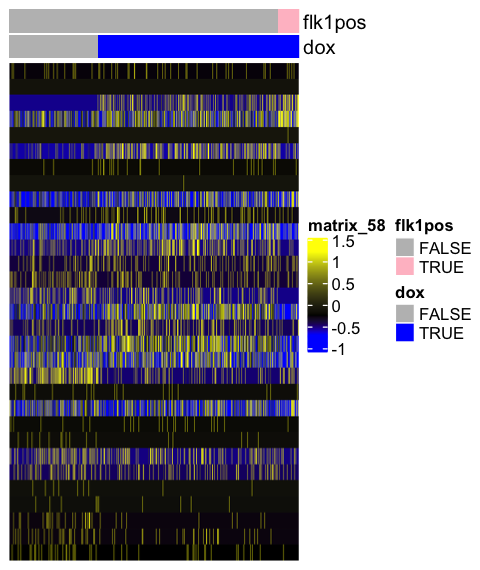

In [300]:
column_annotation <- HeatmapAnnotation(
  flk1pos = is_flk1pos[m],
  dox = is_dox[m],
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray')
  )
)
col_fun <- colorRamp2(quantile(X_sc, c(0.1, 0.5, 0.9)), c("blue", "black", "yellow"))

options(repr.plot.width=4, repr.plot.height=4.75)
Heatmap(
  X_sc,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  top_annotation = column_annotation,
  show_row_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE
)

In [317]:
n <- rowData(dev_EB)$name %in% d_common$symbol
cn <- c('EB_NoDox_D25', 'EB_Dox_D25', 'EB_Dox_D25_Flk1pos')
m <- which(colData(dev_EB)$group %in% cn)
m <- m[order(factor(colData(dev_EB)$group[m], cn))]
is_flk1pos <- grepl('Flk1pos', colData(dev_EB)$group)
is_dox <- grepl('_Dox_', colData(dev_EB)$group)
Y_EB <- assays(dev_EB[n, m])$deviations 
rownames(Y_EB) <- rowData(dev_EB)$name[n]
Y_EB <- Y_EB[d_common$symbol, ]
Y_EB

Fli1,-0.0903149188,-0.089076934,0.0356413091,0.0459939423,0.0521770633,0.0705720136
Fev,-0.0887294027,-0.085402081,0.0334168006,0.0487188551,0.0481065586,0.0683597353
Etv2,-0.1917128626,-0.198481374,0.0924784950,0.1066533863,0.1173855002,0.1272563672
Elk3,-0.0445833074,-0.039637934,0.0126368809,0.0201954220,0.0188146112,0.0449982106
Myt1l,-0.0249435159,-0.015798183,0.0027124658,0.0047280098,0.0226338711,0.0152527290
Ar,-0.0040429287,-0.008665749,0.0067437007,0.0054884711,0.0018856248,0.0004868127
Prdm11,-0.0167024665,-0.012336733,0.0057917655,-0.0037754053,0.0139695259,0.0166136455
Prdm1,-0.0041997540,-0.003628205,-0.0011229150,-0.0002507532,0.0056688623,0.0043470829
Xbp1,-0.0220510634,-0.025703224,-0.0109872137,-0.0042401368,0.0300322462,0.0386775682
Irf9,-0.0174563825,-0.017190942,-0.0004316344,-0.0082642655,0.0237837070,0.0233457201
Smarcc2,-0.0265536229,-0.027622997,0.0091185185,0.0033839221,0.0148790783,0.0346792184


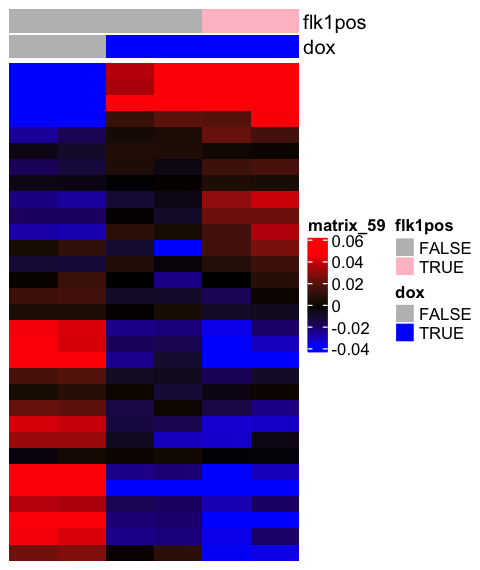

In [318]:
column_annotation <- HeatmapAnnotation(
  flk1pos = is_flk1pos[m],
  dox = is_dox[m],
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray')
  )
)
col_fun <- colorRamp2(quantile(Y_EB, c(0.1, 0.5, 0.9)), c("blue", "black", "red"))

options(repr.plot.width=4, repr.plot.height=4.75)
Heatmap(
  Y_EB,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  top_annotation = column_annotation,
  show_row_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE
)

In [320]:
n <- rowData(dev_MEF)$name %in% d_common$symbol
cn <- c('MEF_NoDox', 'MEF_Dox_D7', 'MEF_Dox_D7_Flk1pos')
m <- which(colData(dev_MEF)$group %in% cn)
m <- m[order(factor(colData(dev_MEF)$group[m], cn))]
is_flk1pos <- grepl('Flk1pos', colData(dev_MEF)$group)
is_dox <- grepl('_Dox_', colData(dev_MEF)$group)
Y_MEF <- assays(dev_MEF[n, m])$deviations 
rownames(Y_MEF) <- rowData(dev_MEF)$name[n]
Y_MEF <- Y_MEF[d_common$symbol, ]
Y_MEF

Fli1,0.001555971,-0.0367999679,-0.116353123,-0.029791537,0.082991794,0.1005947055
Fev,0.008978898,-0.0356285235,-0.123162537,-0.034692305,0.077151588,0.1018798455
Etv2,-0.142504898,-0.1589056821,-0.148343441,-0.047344899,0.216567081,0.2346674237
Elk3,0.057640633,0.0116961448,-0.103170854,-0.020618125,0.037667639,0.0494512133
Myt1l,-0.136307663,-0.0862068069,0.175165547,0.092936539,0.062651143,0.0477859605
Ar,-0.074020625,-0.0446411351,0.075185476,0.032813170,0.029970075,0.0321303639
Prdm11,0.003249528,-0.0365077018,-0.008616890,0.029231771,0.057161702,0.0465077607
Prdm1,-0.006597647,-0.0038884270,0.011656996,0.009129600,-0.003263776,-0.0016587453
Xbp1,0.045725816,0.0205717924,-0.058029654,-0.009569086,0.024266491,0.0451433326
Irf9,0.020536200,-0.0068418031,-0.032173732,0.018036700,0.019313830,0.0502035277
Smarcc2,-0.011763466,0.0004579274,-0.005653587,0.011747385,0.005031562,0.0093070669


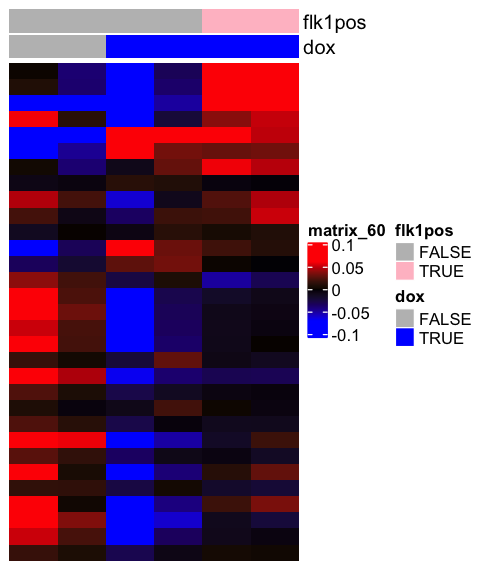

In [321]:
column_annotation <- HeatmapAnnotation(
  flk1pos = is_flk1pos[m],
  dox = is_dox[m],
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray')
  )
)
col_fun <- colorRamp2(quantile(Y_MEF, c(0.1, 0.5, 0.9)), c("blue", "black", "red"))

options(repr.plot.width=4, repr.plot.height=4.75)
Heatmap(
  Y_MEF,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  top_annotation = column_annotation,
  show_row_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE
)

In [390]:
table(d_common$EB_log2FoldChange > 0)



FALSE  TRUE 
   18    13 